In [20]:
%matplotlib inline
from astropy.time import Time
from lsst.summit.utils.efdUtils import makeEfdClient, getEfdData
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from lsst_efd_client import EfdClient
from collections import defaultdict
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
from scipy.stats import norm

# M1M3 hardpoint repeatability and resolution analysis
---

## Overview
This notebook is dedicated to the analysis of M1M3 hardpoint repeatability.

Data to be analyzed are for the Requirement: "LVV-11200 LTS-88-REQ-0015-V-01: 3.7.1.3 Hardpoint Displacement Repeatability and Resolution_1" - https://jira.lsstcorp.org/browse/LVV-11200

There are three key deliverables
- Plot Force vs. displacement for all actuators.
- Make a histogram of the displacement values per actuator.
- From the generated plot, measure the Hardpoint displacement repeatability (Average) and its resolution (FWHM) around 0 Newtons.

## Querying EFD

### Helper Function

In [3]:
async def query_bump_logs_in_chunks(
    start_date, end_date, client_name="", chunk_size_days=3,topic_name="lsst.sal.MTM1M3.logevent_logMessage",fields=["message"]
):
    """
    Queries the log messages related to bump tests from the EFD in chunks.

    Args:
        start_date (str): Start date of the query in ISO format (YYYY-MM-DD).
        
        end_date (str): End date of the query in ISO format (YYYY-MM-DD).
        
        client_name (str, optional): Name of the EFD client. Defaults to "".
        
        chunk_size_days (int, optional): Number of days per chunk. Defaults to 3.

        topic_name (str, optional): SAL topic name to be queried by the client. Defaults to lsst.sal.MTM1M3.logevent_logMessage.

        fields (list[str], optional): Fields to be queried by the client. Defaults to ["message"].

    Returns:
        pandas.DataFrame: Concatenated DataFrame containing the queried log messages.
    """

    client = makeClient(client_name)

    # Convert start and end dates to datetime objects
    start = datetime.fromisoformat(start_date)
    end = datetime.fromisoformat(end_date)

    # Initialize an empty DataFrame to store concatenated results
    all_data = pd.DataFrame()

    current_start = start
    while current_start < end:
        current_end = min(current_start + timedelta(days=chunk_size_days), end)
        try:
            # Query the data for the current chunk
            chunk_data = await client.select_time_series(
                topic_name=topic_name,
                fields=fields,
                start=Time(current_start.isoformat(), format="isot", scale="utc"),
                end=Time(current_end.isoformat(), format="isot", scale="utc"),
            )
            # Concatenate the chunk data to the main DataFrame
            all_data = pd.concat([all_data, chunk_data], ignore_index=False)
        except Exception as e:
            print(
                f"Error querying data from {current_start.isoformat()} to {current_end.isoformat()}: {e}"
            )
            continue  # Optionally, continue to the next chunk

        # Move to the next chunk
        current_start = current_end

    return all_data

def makeClient(client_name):
        # Create the client based on client_name
    if client_name == "summit_efd":
        return makeEfdClient("summit_efd")
    elif client_name == "usdf_efd":
        return makeEfdClient("usdf_efd")
    elif client_name == "idf_efd":
        return makeEfdClient("idf_efd")
    else:
        return makeEfdClient()  # Default client


# Example usage:
# begin = "2023-11-13T01:00"
# end = "2023-12-21T01:00"
# bump_logs = await query_bump_logs_in_chunks(begin, end, client_name='')

## Let's take a look at the topics, so that we can get an idea of what we need to query

In [4]:
client = makeClient("usdf_efd")

a = await client.get_topics() 

In [5]:
for entry in a:
    if entry.__contains__("lsst.sal.MTM1M3"):# and entry.__contains__("isplace"):
        print(entry)

lsst.sal.MTM1M3.accelerometerData
lsst.sal.MTM1M3.ackcmd
lsst.sal.MTM1M3.appliedAccelerationForces
lsst.sal.MTM1M3.appliedAzimuthForces
lsst.sal.MTM1M3.appliedBalanceForces
lsst.sal.MTM1M3.appliedCylinderForces
lsst.sal.MTM1M3.appliedElevationForces
lsst.sal.MTM1M3.appliedForces
lsst.sal.MTM1M3.appliedThermalForces
lsst.sal.MTM1M3.appliedVelocityForces
lsst.sal.MTM1M3.command_abortRaiseM1M3
lsst.sal.MTM1M3.command_applyAberrationForces
lsst.sal.MTM1M3.command_applyActiveOpticForces
lsst.sal.MTM1M3.command_applyActiveOpticForcesByBendingModes
lsst.sal.MTM1M3.command_applyOffsetForces
lsst.sal.MTM1M3.command_applyOffsetForcesByMirrorForce
lsst.sal.MTM1M3.command_boosterValveClose
lsst.sal.MTM1M3.command_boosterValveOpen
lsst.sal.MTM1M3.command_clearActiveOpticForces
lsst.sal.MTM1M3.command_clearOffsetForces
lsst.sal.MTM1M3.command_clearSlewFlag
lsst.sal.MTM1M3.command_disable
lsst.sal.MTM1M3.command_disableForceActuator
lsst.sal.MTM1M3.command_disableHardpointChase
lsst.sal.MTM1M3.comman

### Possibilities for the SAL data

- lsst.sal.MTM1M3.forceActuatorData
- lsst.sal.MTM1M3.forceActuatorPressure
- lsst.sal.MTM1M3.hardpointActuatorData
- lsst.sal.MTM1M3.hardpointMonitorData

In [6]:
await client.get_fields("lsst.sal.MTM1M3.hardpointActuatorData")

['displacement0',
 'displacement1',
 'displacement2',
 'displacement3',
 'displacement4',
 'displacement5',
 'encoder0',
 'encoder1',
 'encoder2',
 'encoder3',
 'encoder4',
 'encoder5',
 'forceMagnitude',
 'fx',
 'fy',
 'fz',
 'measuredForce0',
 'measuredForce1',
 'measuredForce2',
 'measuredForce3',
 'measuredForce4',
 'measuredForce5',
 'mx',
 'my',
 'mz',
 'private_efdStamp',
 'private_host',
 'private_identity',
 'private_kafkaStamp',
 'private_origin',
 'private_rcvStamp',
 'private_revCode',
 'private_seqNum',
 'private_sndStamp',
 'stepsCommanded0',
 'stepsCommanded1',
 'stepsCommanded2',
 'stepsCommanded3',
 'stepsCommanded4',
 'stepsCommanded5',
 'stepsQueued0',
 'stepsQueued1',
 'stepsQueued2',
 'stepsQueued3',
 'stepsQueued4',
 'stepsQueued5',
 'timestamp',
 'xPosition',
 'xRotation',
 'yPosition',
 'yRotation',
 'zPosition',
 'zRotation']

In [79]:
starts = ["2023-11-27T21:25:26","2023-11-28T20:40:38","2023-12-04T21:32:18","2023-12-07T03:34:44"] # From https://lsstc.slack.com/archives/C0567AY64AC/p1715789391584609?thread_ts=1715786982.696169&cid=C0567AY64AC
ends = ["2023-11-27T22:41:17","2023-11-28T21:56:28","2023-12-04T22:45:06","2023-12-07T04:48:29"]

In [80]:
colnames =  ["displacement","measuredForce"]
colors = ["#e01616","#f6f40b","#2affbb","#123cdf","#e51983","#2b8221"]

In [81]:
all_data = pd.DataFrame()
for start,end in zip(starts,ends):
    print(r"Starting query for time range {} - {}".format(start,end),end=" . . . ")
    df_bump = await client.select_time_series(
        "lsst.sal.MTM1M3.hardpointActuatorData", 
        "*", Time(start), Time(end))
    
    all_data = pd.concat([all_data, df_bump], ignore_index=False)
    
    print("Finished")
    del df_bump

Starting query for time range 2023-11-27T21:25:26 - 2023-11-27T22:41:17 . . . Finished
Starting query for time range 2023-11-28T20:40:38 - 2023-11-28T21:56:28 . . . Finished
Starting query for time range 2023-12-04T21:32:18 - 2023-12-04T22:45:06 . . . Finished
Starting query for time range 2023-12-07T03:34:44 - 2023-12-07T04:48:29 . . . Finished


### Plot Force vs. displacement for all actuators.
- Take displacement values from up and down movements for each actuator that is closest to Force = Zero Newton for all repetitions.
- Calculate the average.

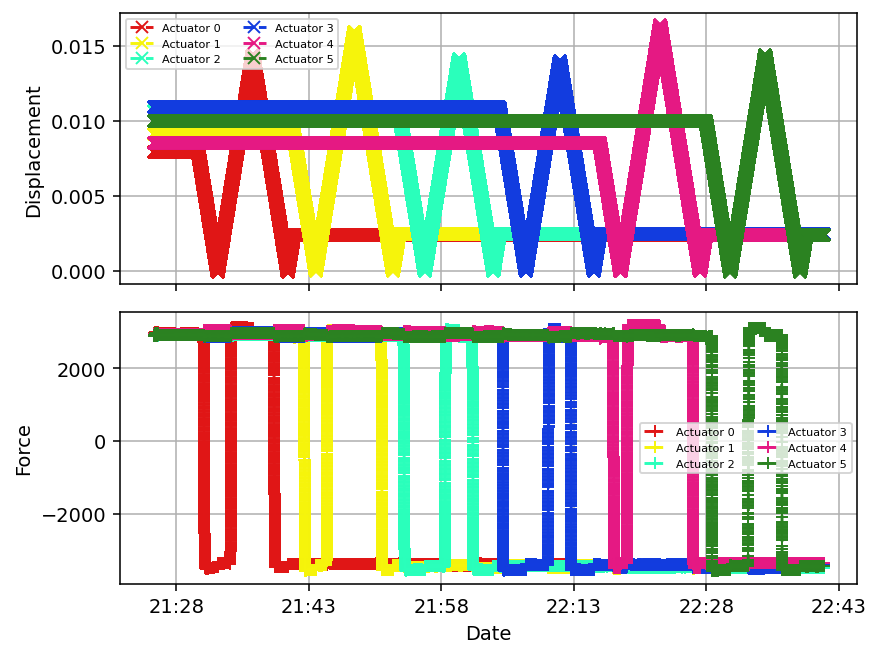

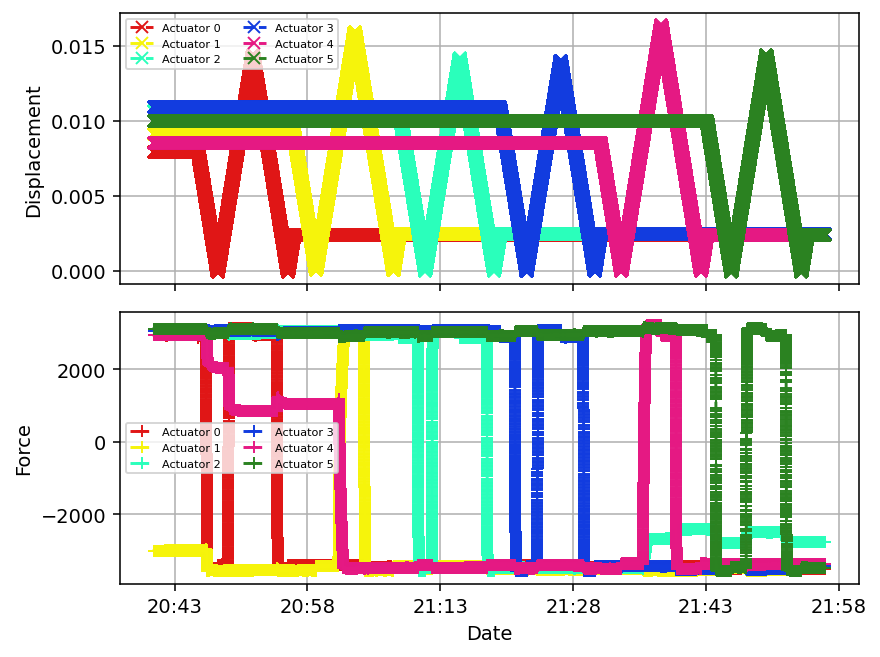

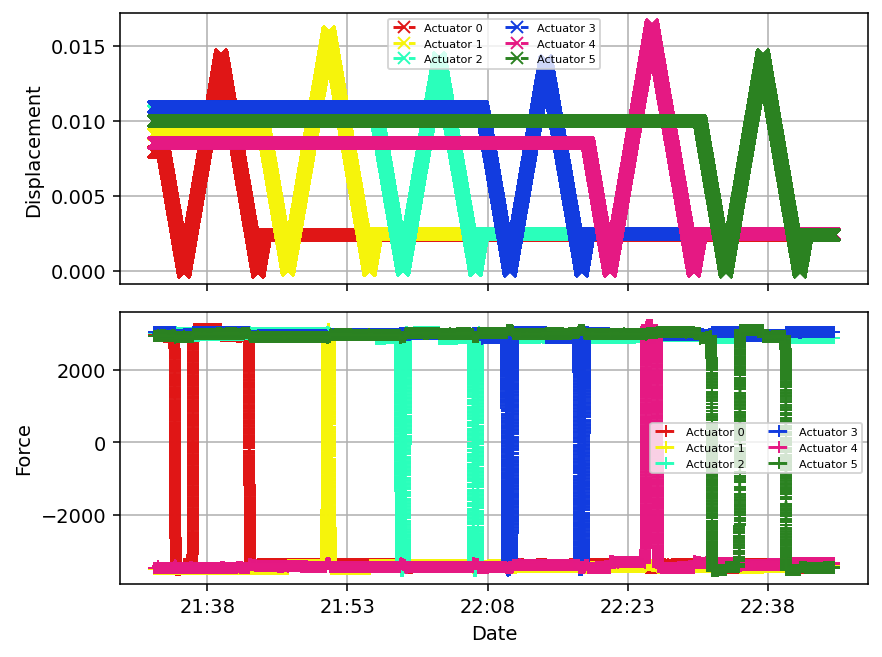

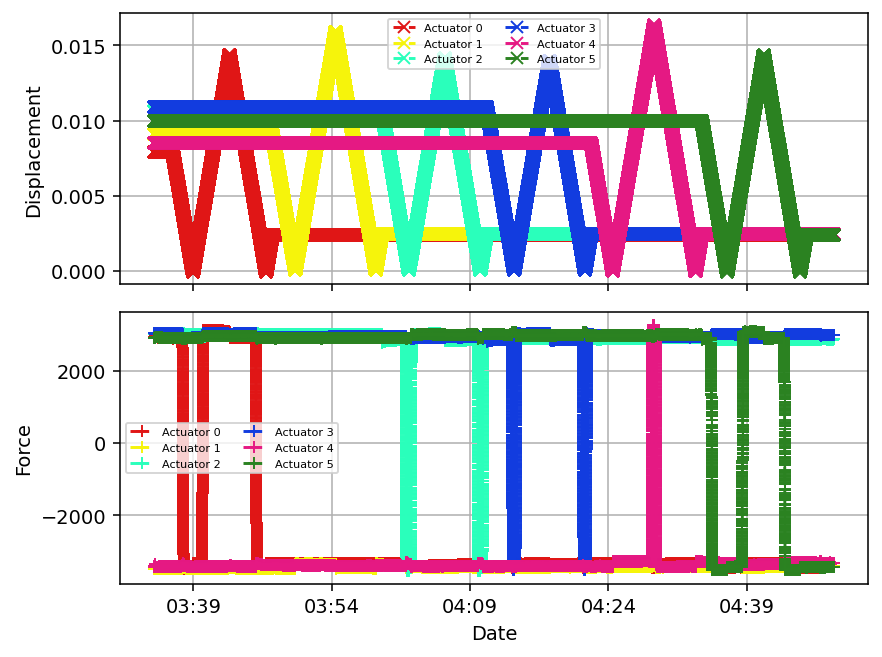

In [84]:
for start,end in zip(starts,ends):
    fig,axs = plt.subplots(2,1,sharex=True,dpi=140)
    mydf = all_data[np.logical_and(Time(all_data.index.values) >= Time(start),Time(all_data.index.values)<=Time(end))]
    for number in range(6):
        axs[0].plot(mydf.index.values,mydf[colnames[0]+str(number)],color=colors[number],
                    label=r"Actuator {}".format(str(number)),marker="x",ls='--')
        axs[1].plot(mydf.index.values,mydf[colnames[1]+str(number)],color=colors[number],
                    label=r"Actuator {}".format(str(number)),marker="+",ls='-.')
        
    axs[0].legend(ncols=2,fontsize='xx-small')
    axs[1].legend(ncols=2,fontsize='xx-small')
    axs[0].set_ylabel("Displacement")
    axs[1].set_ylabel("Force")
    for a in axs:
        a.xaxis.set_major_locator(mdates.MinuteLocator(interval = 15))
        a.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        a.grid()

    axs[1].set_xlabel("Date")

    fig.tight_layout()
    
    fig.savefig(r"/home/s/seanmacb/SITCOM/SITCOM-756/{}_actuator_m1m3.jpg".format(start))

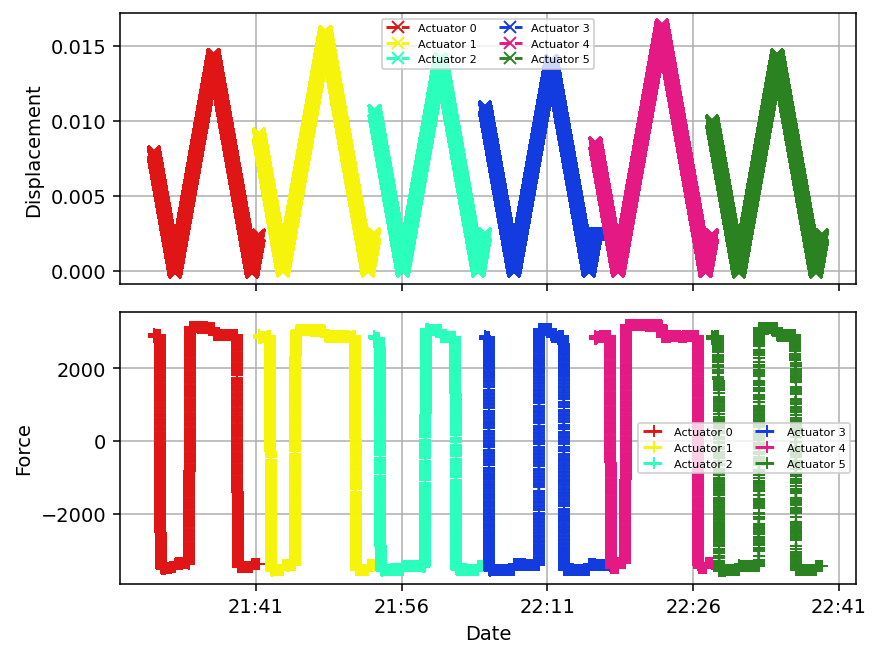

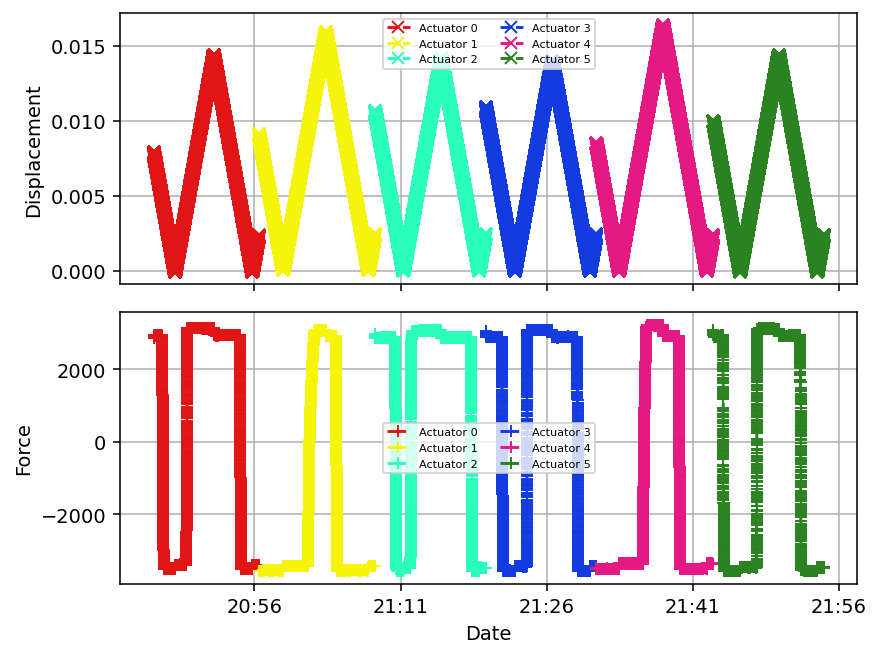

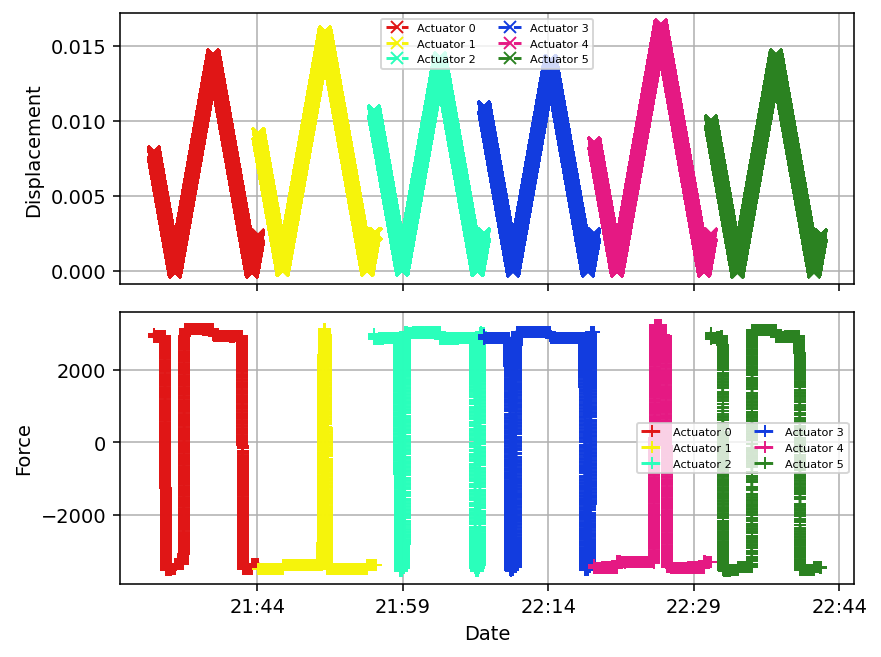

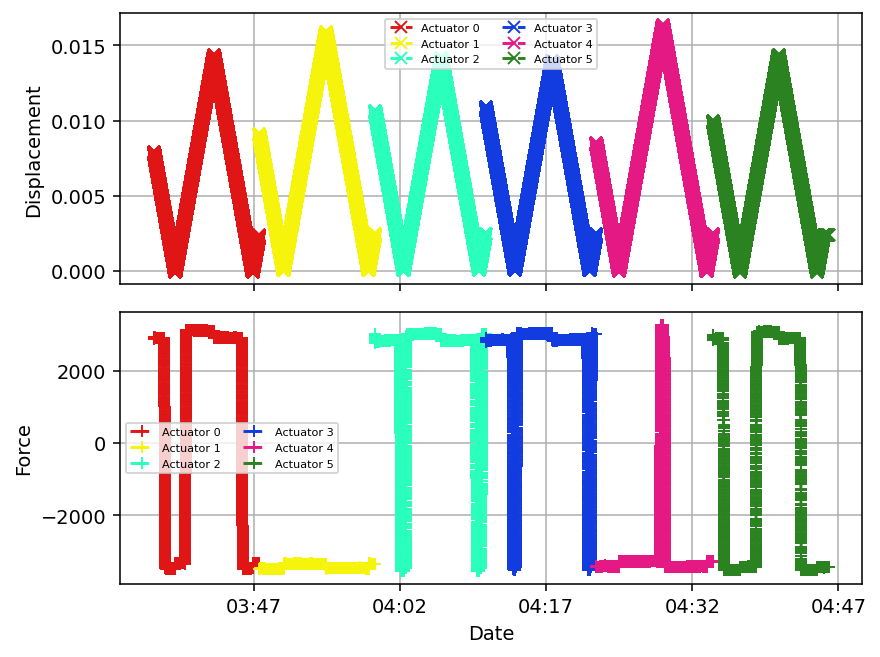

In [107]:
for start,end in zip(starts,ends):
    fig,axs = plt.subplots(2,1,sharex=True,dpi=140)
    mydf = all_data[np.logical_and(Time(all_data.index.values) >= Time(start),Time(all_data.index.values)<=Time(end))]
    for number in range(6):
        date_range = mydf[np.abs(np.diff(mydf[colnames[0]+str(number)],prepend=mydf[colnames[0]+str(number)].iloc[0])) != 0].index.values
        # first dated test for actuator 1 has one point that does not meet the above criteria for masking...
        # popping the last element off with this conditional
        if number == 1 and start==starts[0]:
            date_range = date_range[:-1]
            
        min_date, max_date = np.min(date_range),np.max(date_range)
        
        finaldf = mydf[np.logical_and(Time(mydf.index.values) >= Time(min_date),Time(mydf.index.values)<=Time(max_date))]
        axs[0].plot(finaldf.index.values,finaldf[colnames[0]+str(number)],color=colors[number],label=r"Actuator {}".format(str(number)),marker="x",ls='--')
        axs[1].plot(finaldf.index.values,finaldf[colnames[1]+str(number)],color=colors[number],label=r"Actuator {}".format(str(number)),marker="+",ls='-.')
        
    axs[0].set_ylabel("Displacement")
    axs[1].set_ylabel("Force")
    for a in axs:
        a.xaxis.set_major_locator(mdates.MinuteLocator(interval = 15))
        a.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        a.grid()
        a.legend(ncols=2,fontsize='xx-small')

    axs[1].set_xlabel("Date")

    fig.tight_layout()
    
    fig.savefig(r"/home/s/seanmacb/SITCOM/SITCOM-756/{}_actuator_m1m3_masked.jpg".format(start))

### Make a histogram of the displacement values per actuator.

- Fit a Gaussian distribution and determine the FWHM
- Plot a limit lines at 2um

In [11]:
# Fit a normal distribution to
# the data:
# mean and standard deviation
mu, std = norm.fit(data) 
 
# Plot the histogram.
plt.hist(data, bins=25, density=True, alpha=0.6, color='b')
 
# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 1000)
p = norm.pdf(x, mu, std)
 
plt.plot(x, p, 'k', linewidth=2)
title = "Fit Values: $\mu$={:.2f}, $\sigma$={:.2f}".format(mu, std)
plt.title(title)

NameError: name 'data' is not defined

# From the generated plot, measure the Hardpoint displacement repeatability (Average) and its resolution (FWHM) around 0 Newtons.